In [1]:
%load_ext autoreload
%autoreload 2

import support_functions as sf
import cnn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

%matplotlib inline


# Read in data

In [2]:
emotion_dict = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
image_shape = (48,48,1)
n_classes = len(emotion_dict)
data_folder = "Data" 
model_name = "Model"

In [3]:
# read in data
file_path = './Data/Kaggle-FER/fer2013.csv'
data = sf.read_in_data(file_path) # data is a tuple of (feature_list, label_list, usage_list)

In [4]:
# preprocess: remove blanks, reshape, normalize, & one hot encode
enc_map = list(set(data[1]))
# preprocess data is a tuple of (features, labels, usage_list)
data_preprocess = sf.preprocess(data, image_shape, enc_map)

In [5]:
# split into train, validation, & test sets. Save to file
# Training set = 'Training', validation set = 'PublicTest', test set = 'PrivateTest'
sf.create_train_test_data(data_preprocess, data_folder)

angry


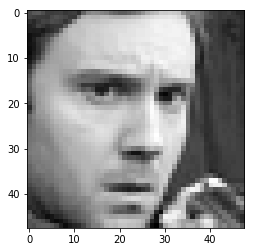

In [11]:
# visualize data
index = 0

img_array = np.reshape(data[0][index], (48,48))
plt.imshow(img_array, cmap='gray')
print(emotion_dict[data[1][index]])



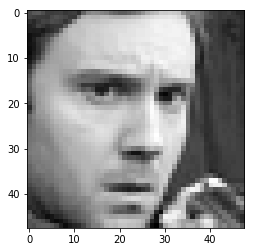

In [12]:
# after preprocess
img_array = np.reshape(data_preprocess[0][index], (48,48))
plt.imshow(img_array, cmap='gray')

# Try current CNN

In [7]:
# Hyperparameters
epochs = 15
batch_size = 256
keep_probability = 0.7

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, [None] + list(image_shape), name='x')
y = tf.placeholder(tf.float32, [None, n_classes], name='y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

print('x shape:', x.get_shape)
print('y shape:', y.get_shape)

# Model
logits = cnn.conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open(data_folder + '/valid.p', mode='rb'))

print('Training...')

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        for batch_features, batch_labels in sf.load_preprocess_training_batch(data_folder, batch_size):
            sess.run(optimizer, feed_dict={x: batch_features, y: batch_labels, keep_prob: keep_probability})
            
        print('Epoch {:>2}'.format(epoch + 1), end=' ')
        loss = sess.run(cost, feed_dict={x: batch_features, y: batch_labels, keep_prob: 1.})
        valid_acc = sess.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.})
        print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))
        
    # Save Model    
    saver = tf.train.Saver()
    save_path = saver.save(sess, model_name)

x shape: <bound method Tensor.get_shape of <tf.Tensor 'x:0' shape=(?, 48, 48, 1) dtype=float32>>
y shape: <bound method Tensor.get_shape of <tf.Tensor 'y:0' shape=(?, 7) dtype=float32>>

 network shape after conv layer: <bound method Tensor.get_shape of <tf.Tensor 'Relu:0' shape=(?, 48, 48, 20) dtype=float32>>

 network shape after pool layer: <bound method Tensor.get_shape of <tf.Tensor 'MaxPool:0' shape=(?, 24, 24, 20) dtype=float32>>

 network shape after flat layer: <bound method Tensor.get_shape of <tf.Tensor 'Reshape:0' shape=(?, 11520) dtype=float32>>

 network shape after fc layer: <bound method Tensor.get_shape of <tf.Tensor 'Relu_1:0' shape=(?, 100) dtype=float32>>

 network shape after dropout layer: <bound method Tensor.get_shape of <tf.Tensor 'dropout/mul:0' shape=(?, 100) dtype=float32>>

 network shape after output layer: <bound method Tensor.get_shape of <tf.Tensor 'Add_1:0' shape=(?, 7) dtype=float32>>
Training...
Epoch  1 Loss:     1.5787 Validation Accuracy: 0.374582

KeyboardInterrupt: 

In [63]:
# test model
cnn.test_model(data_folder, model_name, batch_size)

INFO:tensorflow:Restoring parameters from Model
Testing Accuracy: 0.46442708373069763

